# Example: Monitoring Reforestation Projects
This notebook demonstrates how to work with **VerdeSat** services on a real-world dataset. The GeoJSON below represents three small reforestation projects in Chiapas, Mexico. We'll compute NDVI time series, land-cover metrics, a B-Score, and validate using citizen‑science observations.

In [26]:
geojson_path = "examples/reforestation_plots.geojson"

In [27]:
from verdesat.geo.aoi import AOI
from verdesat.ingestion.earthengine_ingestor import EarthEngineIngestor
from verdesat.ingestion.sensorspec import SensorSpec
from verdesat.analytics.timeseries import TimeSeries
from verdesat.services.landcover import LandcoverService
from verdesat.biodiv.metrics import MetricEngine
from verdesat.biodiv.bscore import BScoreCalculator
from verdesat.biodiv.gbif_validator import OccurrenceService, plot_score_vs_density


In [28]:
aois = AOI.from_geojson(geojson_path, id_col='ID2')
for aoi in aois:
    print(aoi.static_props.get('id'), aoi.geometry.area)

None 2.2290295417198608e-06
None 2.0710699275829863e-06
None 8.769081313212721e-06


In [29]:
from verdesat.services.timeseries import download_timeseries

ts_df = download_timeseries(
    geojson=geojson_path,
    collection='NASA/HLS/HLSL30/v002',
    start='2019-01-01',
    end='2024-12-31',
    scale=30,
    chunk_freq='ME',
    agg='D',
    output='examples/reforestation_ts.csv',
)
ts_df.head()

2025-07-28 19:25:27 [INFO] verdesat.services.timeseries – Loading AOIs from examples/reforestation_plots.geojson
/Users/andreydara/verdesat/code/verdesat/verdesat/ingestion/downloader.py:84: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/andreydara/verdesat/code/verdesat/verdesat/ingestion/downloader.py:84: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/andreydara/verdesat/code/verdesat/verdesat/ingestion/downloader.py:84: FutureWarning:

The behavior of DataFrame concatenation with 

,id,date,mean_ndvi
0,1,2019-01-01,0.824276
1,1,2019-01-02,NaN
2,1,2019-01-03,NaN
3,1,2019-01-04,NaN
4,1,2019-01-05,NaN


In [31]:
import ee
from ee import Reducer
from verdesat.analytics.engine import AnalyticsEngine
sensor = SensorSpec.from_collection_id('NASA/HLS/HLSL30/v002')
base_ic = ee.ImageCollection('NASA/HLS/HLSL30/v002').filterDate('2022-01-01', '2022-12-31')
ndvi_coll = base_ic.map(lambda img: sensor.compute_index(img, 'ndvi'))
composites = AnalyticsEngine.build_composites(
    base_ic=ndvi_coll,
    period='ME',
    reducer=Reducer.mean(),
    start='2022-01-01',
    end='2022-12-31',
    bands=['NDVI'],
    scale=30,
)
composites.size().getInfo()  # number of composites

2025-07-28 19:34:19 [WARNING] googleapiclient.http – Sleeping 1.90 seconds before retry 1 of 5 for request: POST https://earthengine.googleapis.com/v1/projects/ee-andreydara/value:compute?prettyPrint=false&alt=json, after ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2025-07-28 19:35:21 [WARNING] googleapiclient.http – Sleeping 2.34 seconds before retry 2 of 5 for request: POST https://earthengine.googleapis.com/v1/projects/ee-andreydara/value:compute?prettyPrint=false&alt=json, after ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


KeyboardInterrupt: 

In [32]:
from verdesat.analytics.timeseries import TimeSeries
from verdesat.analytics.stats import compute_summary_stats
from verdesat.visualization.visualizer import Visualizer
import pandas as pd, os

ts = TimeSeries.from_dataframe(ts_df, index='ndvi')
ts_monthly = ts.aggregate('ME').fill_gaps()
decomposed = ts_monthly.decompose(period=12)

os.makedirs('examples/decomp', exist_ok=True)
for pid, res in decomposed.items():
    pd.DataFrame({
        'date': res.observed.index,
        'observed': res.observed.values,
        'trend': res.trend.values,
        'seasonal': res.seasonal.values,
        'resid': res.resid.values,
    }).to_csv(f'examples/decomp/{pid}_decomposition.csv', index=False)

trend = AnalyticsEngine.compute_trend(ts_monthly)
stats = compute_summary_stats('examples/reforestation_ts.csv', decomp_dir='examples/decomp', period=12)
stats.to_dataframe()

,Site ID,Start Date,End Date,Num Periods,% Gapfilled,Mean NDVI,Median NDVI,Min NDVI,Max NDVI,Std NDVI,Sen's Slope (NDVI/yr),Trend ΔNDVI,Mann–Kendall p-value,Seasonal Amplitude,Peak Month,Residual RMS
0,1,2019-01,2024-12,2178,NaN,0.761404,0.765169,0.541452,0.893406,0.054653,-0.002310,-0.005403,0.055700,0.108246,2019-08,0.033910
1,2,2019-01,2024-12,2178,NaN,0.625843,0.628658,0.400309,0.847535,0.107592,-0.011532,-0.017681,0.000002,0.238489,2019-09,0.024385
2,3,2019-01,2024-12,2178,NaN,0.685285,0.683405,0.540685,0.806831,0.064848,-0.000279,0.005142,0.858266,0.145770,2019-07,0.017901


In [33]:
viz = Visualizer()
viz.plot_time_series(ts_monthly.df, 'mean_ndvi', 'examples/ndvi_timeseries.png', agg_freq='ME')
viz.plot_timeseries_html(ts_monthly.df, 'mean_ndvi', 'examples/ndvi_timeseries.html', agg_freq='ME')
for pid, res in decomposed.items():
    viz.plot_decomposition(res, f'examples/decomp/{pid}_decomp.png')
trend.to_dataframe()

,id,date,trend
0,1,2019-01-31,0.756737
1,1,2019-02-28,0.756878
2,1,2019-03-31,0.757035
3,1,2019-04-30,0.757186
4,1,2019-05-31,0.757342
...,...,...,...
211,3,2024-08-31,0.713189
212,3,2024-09-30,0.713713
213,3,2024-10-31,0.714255
214,3,2024-11-30,0.714779


2025-07-28 19:38:16 [INFO] verdesat.services.bscore – Loading AOIs from examples/reforestation_plots.geojson
2025-07-28 19:38:16 [INFO] verdesat.services.bscore – Loading landcover image projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS
2025-07-28 19:38:20 [INFO] verdesat.services.bscore – ✔ Converted to COG: /var/folders/bc/p78br9810cd0yyjhgq_sz2kc0000gn/T/tmpfkqz93wz/LANDCOVER_1_2021.tiff
2025-07-28 19:38:20 [INFO] verdesat.services.bscore – Wrote landcover raster to /var/folders/bc/p78br9810cd0yyjhgq_sz2kc0000gn/T/tmpfkqz93wz/LANDCOVER_1_2021.tiff
2025-07-28 19:38:20 [INFO] verdesat.services.bscore – Loading landcover image projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS
2025-07-28 19:38:22 [INFO] verdesat.services.bscore – ✔ Converted to COG: /var/folders/bc/p78br9810cd0yyjhgq_sz2kc0000gn/T/tmp0m61q937/LANDCOVER_2_2021.tiff
2025-07-28 19:38:22 [INFO] verdesat.services.bscore – Wrote landcover raster to /var/folders/bc/p78br9810cd0yyjhgq_sz2kc0000gn/T/t

,Start Date,End Date,Num Periods,% Gapfilled,Mean NDVI,Median NDVI,Min NDVI,Max NDVI,Std NDVI,Sen's Slope (NDVI/yr),Trend ΔNDVI,Mann–Kendall p-value,Seasonal Amplitude,Peak Month,Residual RMS,id,bscore
Site ID,,,,,,,,,,,,,,,,,
1,2019-01,2024-12,2178,NaN,0.761404,0.765169,0.541452,0.893406,0.054653,-0.002310,-0.005403,0.055700,0.108246,2019-08,0.033910,1,61.818512
2,2019-01,2024-12,2178,NaN,0.625843,0.628658,0.400309,0.847535,0.107592,-0.011532,-0.017681,0.000002,0.238489,2019-09,0.024385,2,53.621753
3,2019-01,2024-12,2178,NaN,0.685285,0.683405,0.540685,0.806831,0.064848,-0.000279,0.005142,0.858266,0.145770,2019-07,0.017901,3,75.401491


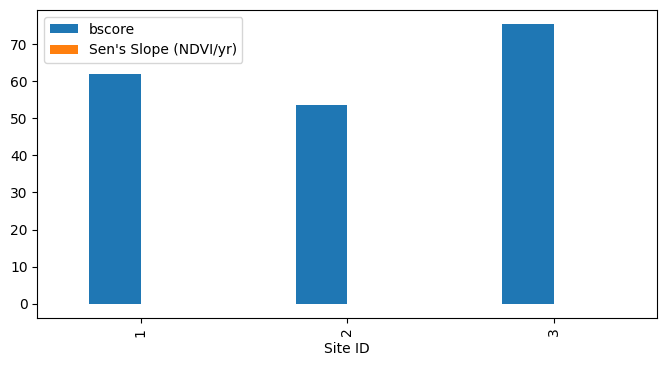

In [37]:

from verdesat.services.bscore import compute_bscores
df_stats = stats.to_dataframe()
df_scores = compute_bscores(geojson_path, year=2021, output='examples/bscore.csv')
df = df_stats.merge(df_scores, left_on='Site ID', right_on='id').set_index('Site ID')
df[['bscore', "Sen's Slope (NDVI/yr)"]].plot.bar(figsize=(8,4))
df.head()

In [ ]:
# All plots have been written to the examples directory.

### What do the metrics tell us?

* **Mean NDVI** represents the average greenness of each plot over time.
* **Seasonal amplitude** captures the difference between peak and trough NDVI values, highlighting intra‑annual variability.
* **Sen's slope** estimates the yearly change in NDVI after removing seasonal effects.
* **Residual RMS** indicates how much short‑term noise remains after decomposition.

Together these metrics help compare the three reforestation plots and understand which ones are improving the fastest.